  0%|          | 0/5000 [00:00<?, ?it/s]

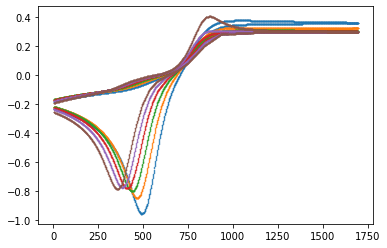

  0%|          | 0/5000 [00:00<?, ?it/s]

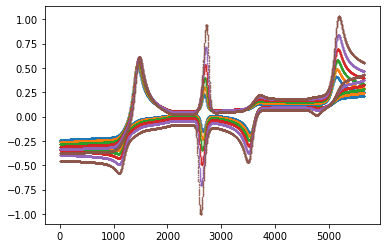

  0%|          | 0/5000 [00:00<?, ?it/s]

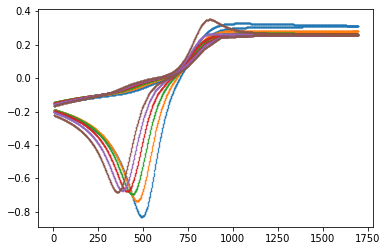

  0%|          | 0/5000 [00:00<?, ?it/s]

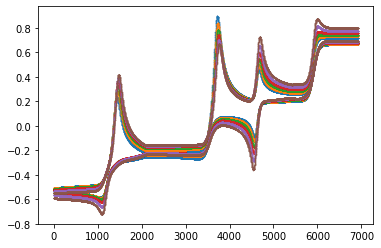

  0%|          | 0/5000 [00:00<?, ?it/s]

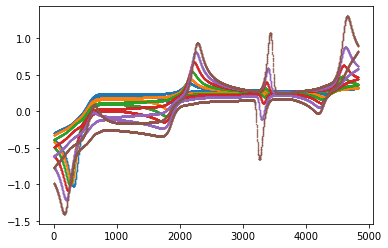

  0%|          | 0/5000 [00:00<?, ?it/s]

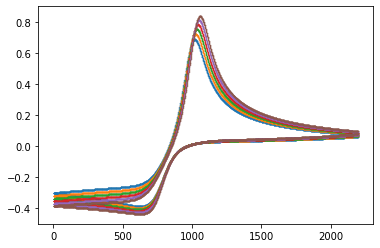

  0%|          | 0/5000 [00:00<?, ?it/s]

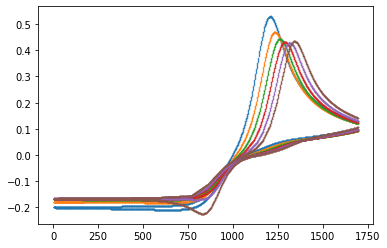

  0%|          | 0/5000 [00:00<?, ?it/s]

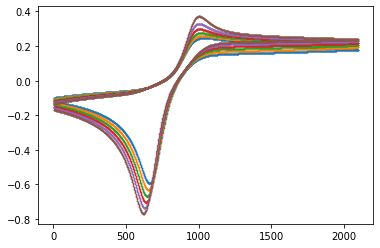

  0%|          | 0/5001 [00:00<?, ?it/s]

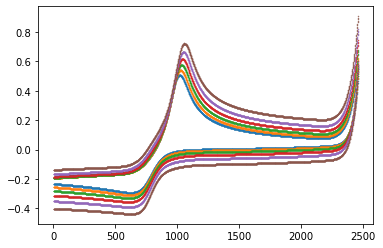

  0%|          | 0/5000 [00:00<?, ?it/s]

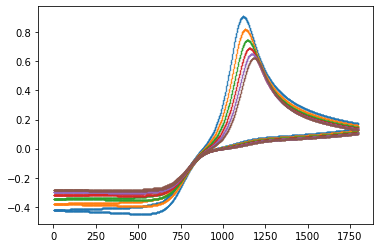

  0%|          | 0/5000 [00:00<?, ?it/s]

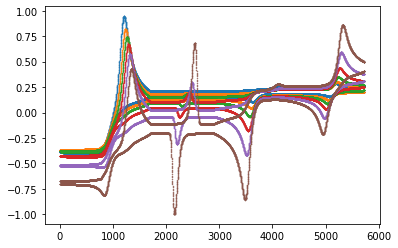

  0%|          | 0/5000 [00:00<?, ?it/s]

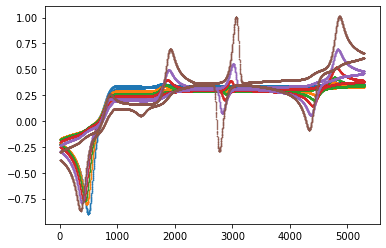

  0%|          | 0/5000 [00:00<?, ?it/s]

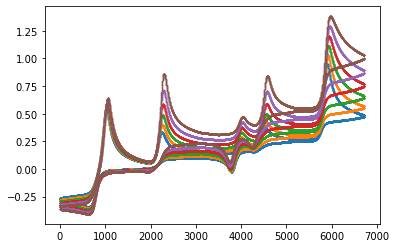

  0%|          | 0/5000 [00:00<?, ?it/s]

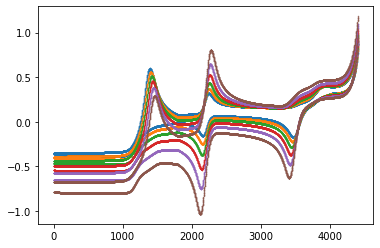

  0%|          | 0/5000 [00:00<?, ?it/s]

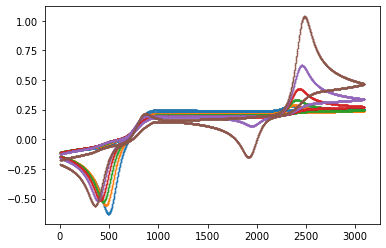

  0%|          | 0/4999 [00:00<?, ?it/s]

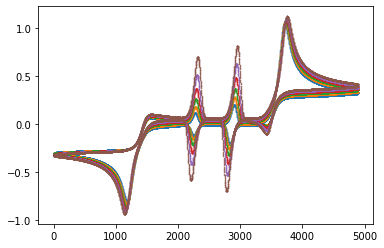

  0%|          | 0/5000 [00:00<?, ?it/s]

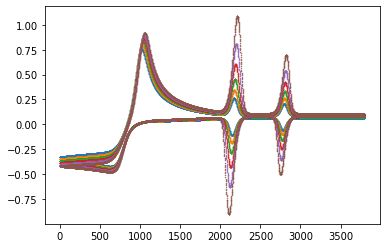

  0%|          | 0/5000 [00:00<?, ?it/s]

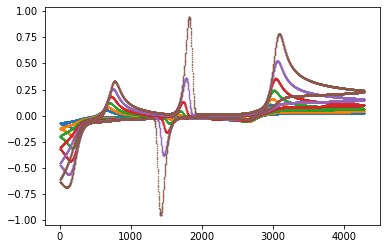

  0%|          | 0/5000 [00:00<?, ?it/s]

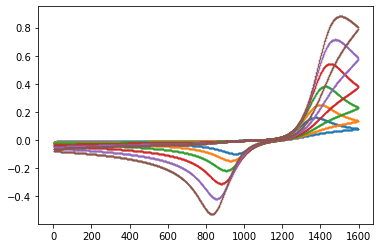

  0%|          | 0/5000 [00:00<?, ?it/s]

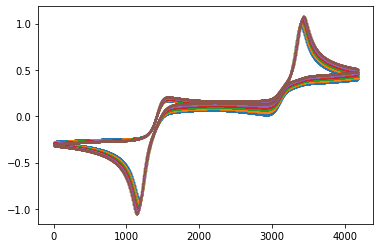

  0%|          | 0/5000 [00:00<?, ?it/s]

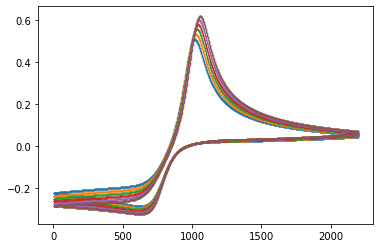

  0%|          | 0/5000 [00:00<?, ?it/s]

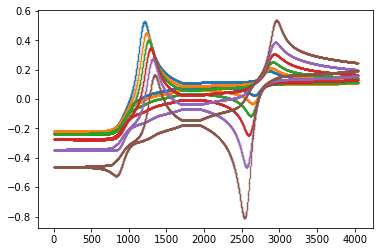

  0%|          | 0/5000 [00:00<?, ?it/s]

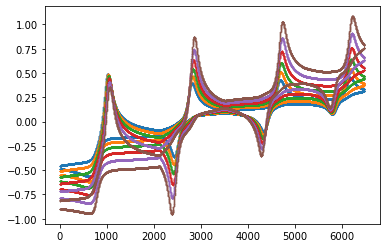

  0%|          | 0/5000 [00:00<?, ?it/s]

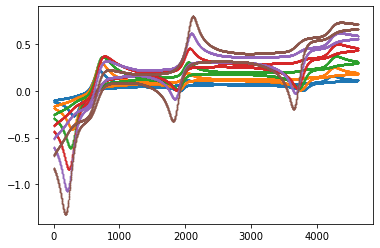

  0%|          | 0/5001 [00:00<?, ?it/s]

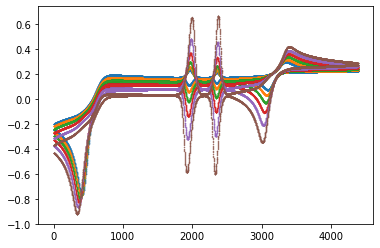

  0%|          | 0/5000 [00:00<?, ?it/s]

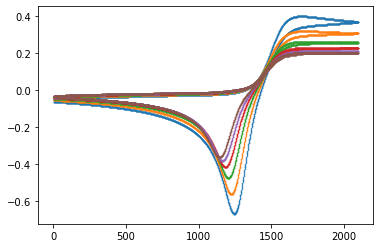

  0%|          | 0/5000 [00:00<?, ?it/s]

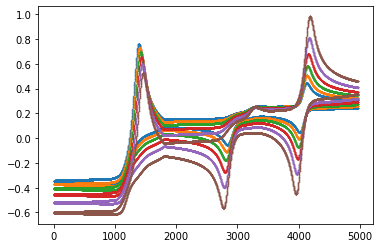

  0%|          | 0/5000 [00:00<?, ?it/s]

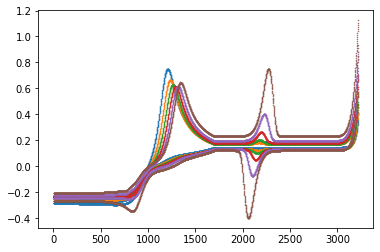

  0%|          | 0/5000 [00:00<?, ?it/s]

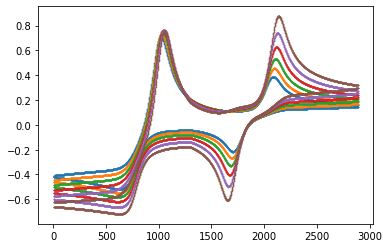

  0%|          | 0/5000 [00:00<?, ?it/s]

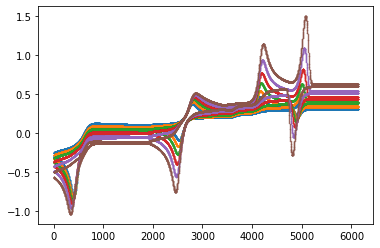

  0%|          | 0/5000 [00:00<?, ?it/s]

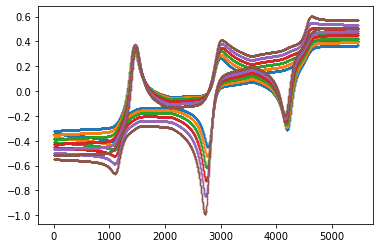

  0%|          | 0/4999 [00:00<?, ?it/s]

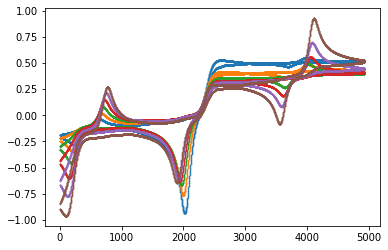

  0%|          | 0/5000 [00:00<?, ?it/s]

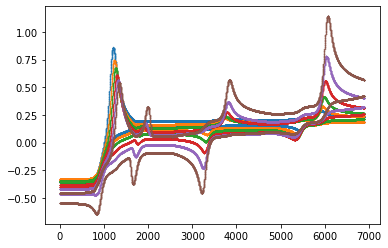

  0%|          | 0/5000 [00:00<?, ?it/s]

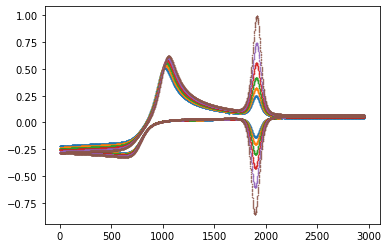

  0%|          | 0/5000 [00:00<?, ?it/s]

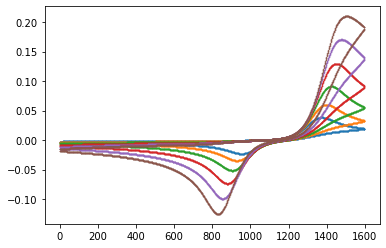

  0%|          | 0/5000 [00:00<?, ?it/s]

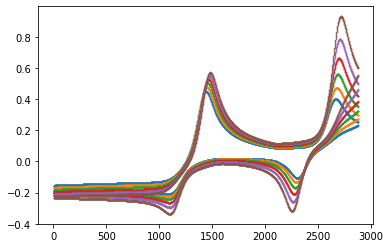

  0%|          | 0/5000 [00:00<?, ?it/s]

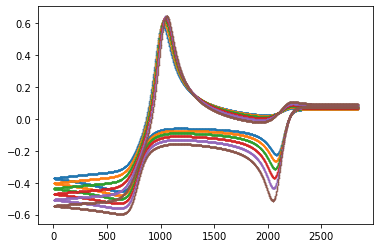

  0%|          | 0/5000 [00:00<?, ?it/s]

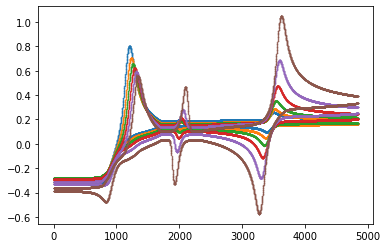

  0%|          | 0/5000 [00:00<?, ?it/s]

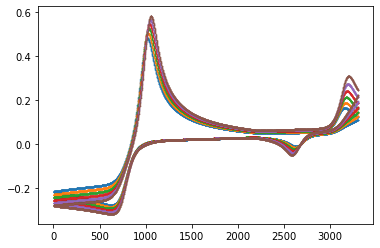

  0%|          | 0/5000 [00:00<?, ?it/s]

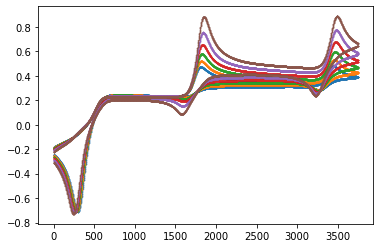

  0%|          | 0/5001 [00:00<?, ?it/s]

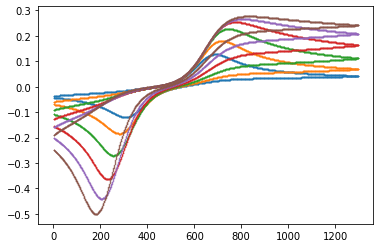

  0%|          | 0/5000 [00:00<?, ?it/s]

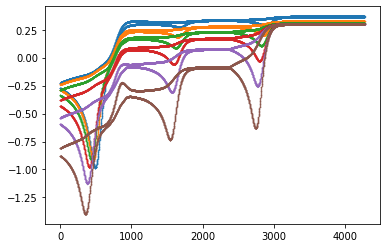

  0%|          | 0/5000 [00:00<?, ?it/s]

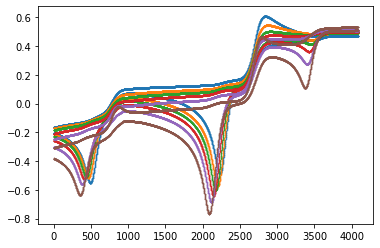

  0%|          | 0/5000 [00:00<?, ?it/s]

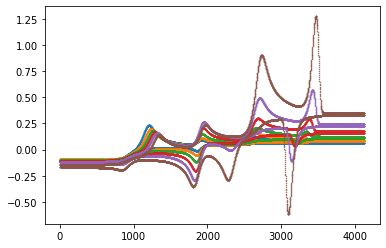

  0%|          | 0/5000 [00:00<?, ?it/s]

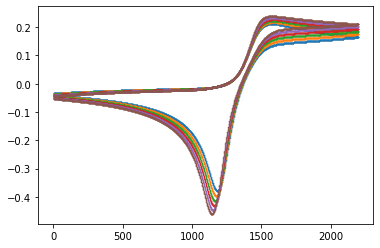

  0%|          | 0/5000 [00:00<?, ?it/s]

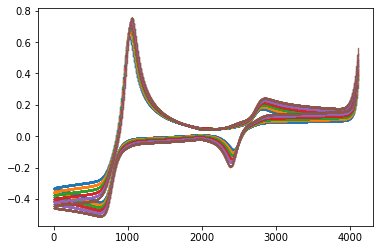

  0%|          | 0/5000 [00:00<?, ?it/s]

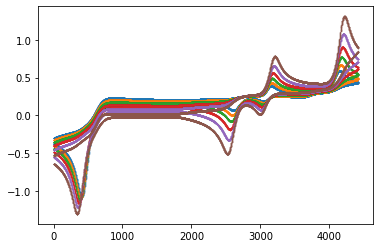

  0%|          | 0/4999 [00:00<?, ?it/s]

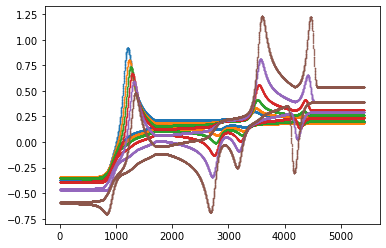

100%|██████████| 4999/4999 [06:35<00:00, 12.63it/s]


<Figure size 432x288 with 0 Axes>

In [21]:
# Quality Control Script

import os, pickle, matplotlib.pyplot as plt, random as r, numpy as np
from tqdm import tqdm

# CHECKS MADE - A chunk of data is all of the data with a specific scan rate
# 1. Are there 6 scan rates in mergeCV
# 2. Are the indices in order
# 3. Do the chunks of indices only contain one scan rate (ex. indices 1-10 have x, indices 11-20 have y, etc)
# 4. Does the data frame chunked by index have the same data as that chunked by scan rate
# 5. Is each chunk mirrored (min to max V value, then max to min V value)
# 6. Is each chunk the same length 
# 7. Are the scan rates in increasing order

folders = ['20230308', '20230309', '20230310']
for folder in folders:
    paths = [path.path for path in os.scandir(f'./{folder}/Generated_Data/')]
    for path in paths:
        files = os.listdir(path)
        for i in tqdm(range(len(os.listdir(path)))):
            file = f'{path}/{files[i]}'
            data = pickle.load(open(file, 'rb'))
            if len(data['v'].unique()) != 6:
                print("SR Count ERROR")
            lengths = set()
            prev_max = 0
            prev_v = 0
            for v in data['v'].unique():
                t = data.loc[data['v'] == v]
                if i % 10000 == 0:
                    plt.scatter(t['V'], t['A'], s=0.2)
                n = len(t)
                indices = t.index
                if min(indices) < prev_max:
                    print('ORDER ERROR')
                t2 = data.loc[prev_max+1:max(indices)]
                if len(t2['v'].unique()) != 1 or t2['v'].unique()[0] != v:
                    print("SORT ERROR")
                prev_max = max(indices)
                if v <= prev_v:
                    print("INCREASING SR ERROR")
                prev_v = v
                start = t.loc[indices[0], 'V']
                mid_end = t.loc[indices[(n//2)-1], 'V']
                mid_start = t.loc[indices[(n//2)], 'V']
                end = t.loc[indices[-1], 'V']
                if start != end or mid_end != mid_start:
                    print("Mirror Error")
                lengths.add(n)
            if len(lengths) != 1:
                print("Length of Chunk ERROR")
            if i % 10000 == 0:
                plt.show()
                plt.clf()


In [30]:
# Preprocess for ECP custom case removal
import os, pandas as pd, shutil
from matplotlib import pyplot as plt
from tqdm import tqdm

path = 'D:/MergeCV/Samples/ECP/'
trash = 'D:/MergeCV/TRASH/ECP_ScanRateFlips/'
gen = (file for file in os.scandir(path) if file.name.endswith('txt'))

def get_end_i(df):
    max_V_is = df.loc[f['V'] == max(df['V'])].index
    return df.loc[max_V_is[0], 'A']

err_count = 0
total_count = 0
for file in tqdm(gen):
    total_count += 1
    f = pd.read_csv(file.path)
    srs = f['v'].unique()
    low_end = f.loc[f['v'] == srs[0]]
    high_end = f.loc[f['v'] == srs[-1]]
    if (
        get_end_i(low_end)/get_end_i(high_end) >= 1.1 or
        abs(min(high_end['A'])) / max(high_end['A']) > 0.20 or
        len(srs) != 6 or
        len(f) % 6 != 0
    ):
        err_count += 1
        shutil.move(file.path, f'{trash}{file.name}')
        shutil.move(file.path[:-4], f'{trash}{file.name[:-4]}')
        print(file.path)
print(f'Total: {total_count}, Errs: {err_count}')

1808it [00:29, 63.09it/s]

D:/MergeCV/Samples/ECP/ECP_51433.txt


1896it [00:31, 57.76it/s]

D:/MergeCV/Samples/ECP/ECP_51764.txt


1915it [00:31, 58.42it/s]

D:/MergeCV/Samples/ECP/ECP_51838.txt


2660it [00:44, 60.37it/s]

Total: 2660, Errs: 3


In [9]:
import os, pandas as pd, pickle, matplotlib.pyplot as plt
from IPython.display import clear_output
reports = os.listdir('./20221128/Reports/')
reports = [f for f in reports if f.startswith('info')]
labels = pd.DataFrame()
for rep in reports:
    df = pd.read_csv('./20221128/Reports/' + rep)
    labels = pd.concat([labels, df])

path = './forChong/'
answers = {}
print(len(os.listdir(path)))
for file in os.listdir(path):
    df = pickle.load(open(path + file, 'rb'))
    info = file.split("_")
    mechs = []
    for i in range(4):  
        mechs.append(info[i*2])
    print(mechs)
    plt.scatter(df['V'], df['A'], c=df['v'], cmap='viridis', s=0.05)
    plt.show()
    todel = input()
    if todel == 'd':
        os.remove(path + file)
    else:
        mech_df = labels.loc[labels['File'] == file[:-4]]
        mechs = list(mech_df['Mechanism'])
        answers[file] = mechs
    plt.clf()
    clear_output()

print(len(os.listdir(path)))
df = pd.DataFrame.from_dict(answers, orient='index')
df


87


,0,1,2,3
CE_1701_CE_3596_E_4527_T_50760_132906374_data,ECa,ECa,E,T
CE_2136_EC_1711_ECE_3355_E_5684_13332647_data,ECb,ECa,ECE,E
CE_26_DISP_2777_E_345_EC_2176_133949741_data,ECb,DISP,E,ECa
DISP_10328_SR_108_E_7470_ECE_8458_133103475_data,DISP,SR,E,ECE
DISP_10452_E_12462_E_8078_ECE_8928_133513717_data,DISP,E,E,ECE
...,...,...,...,...
SR_4708_ECE_6344_EC_77_T_50824_133502191_data,SR,ECE,ECa,T
SR_4712_SR_865_E_3185_T_51035_133311581_data,SR,SR,E,T
SR_4762_E_5615_EC_2629_E_3854_133356219_data,SR,E,ECb,E
T_1496_CE_154_EC_599_SR_2670_133827864_data,T,ECa,ECa,SR


<Figure size 432x288 with 0 Axes>

In [11]:
df.to_csv('MergeCV_Answerkey.csv', index=True)

In [17]:
import os, matplotlib.pyplot as plt, pandas as pd, pickle

for file in os.listdir('./forChong/'):
    if file == 'answer_key' or file == 'data':
        continue
    df = pickle.load(open('./forChong/' + file, 'rb'))
    plt.scatter(df['V'], df['A'], c=df['v'], cmap='winter', s=0.05)
    plt.title(file)
    plt.ylabel('Relative Current')
    plt.xlabel('Relative Potential')
    plt.savefig(f'./forChong/data/{file[:-4]}.png', dpi=200)
    plt.clf()
    df.to_csv(f'./forChong/data/{file}.csv', index=False)


<Figure size 432x288 with 0 Axes>